In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ltfs-2020/train_fwYjLYX.csv
/kaggle/input/ltfs-2020/test_1eLl9Yf.csv
/kaggle/input/ltfs-2020/sample_submission_IIzFVsf.csv


In [2]:
train=pd.read_csv('/kaggle/input/ltfs-2020/train_fwYjLYX.csv')
test=pd.read_csv('/kaggle/input/ltfs-2020/test_1eLl9Yf.csv')
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
train.head()

application_date  segment  branch_id        state  zone  case_count
0       2017-04-01        1        1.0  WEST BENGAL  EAST        40.0
1       2017-04-03        1        1.0  WEST BENGAL  EAST         5.0
2       2017-04-04        1        1.0  WEST BENGAL  EAST         4.0
3       2017-04-05        1        1.0  WEST BENGAL  EAST       113.0
4       2017-04-07        1        1.0  WEST BENGAL  EAST        76.0

In [4]:
train['application_date']=pd.to_datetime(train['application_date'],format='%Y-%m-%d')
test['application_date']=pd.to_datetime(test['application_date'],format='%Y-%m-%d')

In [5]:
train_s1=train[train['segment']==1].groupby(['application_date']).sum().reset_index()[['application_date','case_count']].sort_values('application_date')
train_s2=train[train['segment']==2].groupby(['application_date']).sum().reset_index()[['application_date','case_count']].sort_values('application_date')
test_s1=test[test['segment']==1][['application_date']].sort_values('application_date')
test_s2=test[test['segment']==2][['application_date']].sort_values('application_date')

In [6]:
hol=['2017-02-24','2017-03-13','2017-03-28','2017-04-05','2017-04-09','2017-04-14','2017-05-10','2017-06-25'
,'2017-06-26','2017-08-07','2017-09-30','2017-10-02','2017-10-19','2018-02-24','2018-03-13','2018-03-28','2018-04-05','2018-04-09','2018-04-14','2018-05-10','2018-06-25',
'2018-06-26','2018-08-07','2018-09-30','2018-10-02','2018-10-19','2019-02-24','2019-03-13','2019-03-28','2019-04-05','2019-04-09','2019-04-14','2019-05-10','2019-06-25',
'2019-06-26','2019-08-07','2019-09-30','2019-10-02','2019-10-19']

import holidays
ind_holidays = holidays.IND(years=[2017,2018,2019])

from datetime import date
# hol=[]
for date, name in sorted(ind_holidays.items()):
    print(str(date),name)
    hol.append(str(date))
hol

train_s1['hol']=train_s1.application_date.isin(hol)
test_s1['hol']=test_s1.application_date.isin(hol)
hol

2017-01-14 Makar Sankranti / Pongal
2017-01-26 Republic Day
2017-05-01 Labour Day
2017-08-15 Independence Day
2017-10-02 Gandhi Jayanti
2017-12-25 Christmas
2018-01-14 Makar Sankranti / Pongal
2018-01-26 Republic Day
2018-05-01 Labour Day
2018-08-15 Independence Day
2018-10-02 Gandhi Jayanti
2018-12-25 Christmas
2019-01-14 Makar Sankranti / Pongal
2019-01-26 Republic Day
2019-05-01 Labour Day
2019-08-15 Independence Day
2019-10-02 Gandhi Jayanti
2019-12-25 Christmas


['2017-02-24',
 '2017-03-13',
 '2017-03-28',
 '2017-04-05',
 '2017-04-09',
 '2017-04-14',
 '2017-05-10',
 '2017-06-25',
 '2017-06-26',
 '2017-08-07',
 '2017-09-30',
 '2017-10-02',
 '2017-10-19',
 '2018-02-24',
 '2018-03-13',
 '2018-03-28',
 '2018-04-05',
 '2018-04-09',
 '2018-04-14',
 '2018-05-10',
 '2018-06-25',
 '2018-06-26',
 '2018-08-07',
 '2018-09-30',
 '2018-10-02',
 '2018-10-19',
 '2019-02-24',
 '2019-03-13',
 '2019-03-28',
 '2019-04-05',
 '2019-04-09',
 '2019-04-14',
 '2019-05-10',
 '2019-06-25',
 '2019-06-26',
 '2019-08-07',
 '2019-09-30',
 '2019-10-02',
 '2019-10-19',
 '2017-01-14',
 '2017-01-26',
 '2017-05-01',
 '2017-08-15',
 '2017-10-02',
 '2017-12-25',
 '2018-01-14',
 '2018-01-26',
 '2018-05-01',
 '2018-08-15',
 '2018-10-02',
 '2018-12-25',
 '2019-01-14',
 '2019-01-26',
 '2019-05-01',
 '2019-08-15',
 '2019-10-02',
 '2019-12-25']

In [7]:
train_s1.case_count.describe()

count      806.000000
mean      2714.689826
std       2042.418090
min          1.000000
25%       1633.250000
50%       2602.000000
75%       3333.000000
max      21885.000000
Name: case_count, dtype: float64

In [8]:
def create_features(df, label=None,seg=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.application_date
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['week'] = df['date'].dt.week
    df['is_month_start']=df['date'].dt.is_month_start
    df['is_month_end']=df['date'].dt.is_month_end
    df['is_quarter_start']=df['date'].dt.is_quarter_start
    df['is_quarter_end']=df['date'].dt.is_quarter_end
    df['is_year_start']=df['date'].dt.is_year_start
    df['is_year_end']=df['date'].dt.is_year_end
    df['Semester'] = np.where(df['quarter'].isin([1,2]),1,2)
    
    X = df.drop(['date','application_date'],axis=1)
    if label:
        y = df[label]
        return X
    return X

Xtrain_s1 = create_features(train_s1, label='case_count',seg='1')
Xtest_s1= create_features(test_s1)

In [9]:
Xtrain_s1.head()

case_count    hol  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0       299.0  False          5        2      4  2017         91           1   
1        42.0  False          0        2      4  2017         93           3   
2        23.0  False          1        2      4  2017         94           4   
3      1530.0   True          2        2      4  2017         95           5   
4      1341.0  False          4        2      4  2017         97           7   

   week  is_month_start  is_month_end  is_quarter_start  is_quarter_end  \
0    13            True         False              True           False   
1    14           False         False             False           False   
2    14           False         False             False           False   
3    14           False         False             False           False   
4    14           False         False             False           False   

   is_year_start  is_year_end  Semester  
0          False        False         1  
1          False        False         1  
2          False        False         1  
3          False        False         1  
4          False        False         1

In [10]:
Xtrain_s1['Semester'].value_counts()

1    442
2    364
Name: Semester, dtype: int64

In [11]:
Xtrain_s1.case_count.describe()

count      806.000000
mean      2714.689826
std       2042.418090
min          1.000000
25%       1633.250000
50%       2602.000000
75%       3333.000000
max      21885.000000
Name: case_count, dtype: float64

In [12]:
Xtrain_s1 = Xtrain_s1[Xtrain_s1['case_count']>15]
Xtrain_s1 = Xtrain_s1[Xtrain_s1['case_count']<=8000]
Xtrain_s1=Xtrain_s1.reset_index().drop('index',axis=1)

In [13]:
Xtrain_s2 = create_features(train_s2, label='case_count',seg='2')
Xtest_s2= create_features(test_s2,seg='2')

In [14]:
Xtrain_s2[Xtrain_s2['case_count']>40000]

case_count  dayofweek  quarter  month  year  dayofyear  dayofmonth  week  \
474     43340.0          3        3      7  2018        200          19    29   

     is_month_start  is_month_end  is_quarter_start  is_quarter_end  \
474           False         False             False           False   

     is_year_start  is_year_end  Semester  
474          False        False         2

In [15]:
Xtrain_s2 = Xtrain_s2[Xtrain_s2['case_count']<40000]
Xtrain_s2=Xtrain_s2.reset_index().drop('index',axis=1)

In [17]:
from catboost import CatBoostClassifier,Pool, cv,CatBoostRegressor
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

In [19]:
col_to_drop=['case_count']
X,y=Xtrain_s1.drop(col_to_drop,axis=1),Xtrain_s1['case_count']
Xtest=Xtest_s1

In [20]:
print(X.shape,Xtest.shape)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state = 1994)

(780, 15) (87, 15)


In [22]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
rf=DecisionTreeRegressor(random_state=1994,max_leaf_nodes=110,max_depth=10)
rf.fit(X_train,y_train)

p=rf.predict(X_val)

print('MAPE',mean_absolute_percentage_error(y_val,p))

MAPE 117.7627335589473


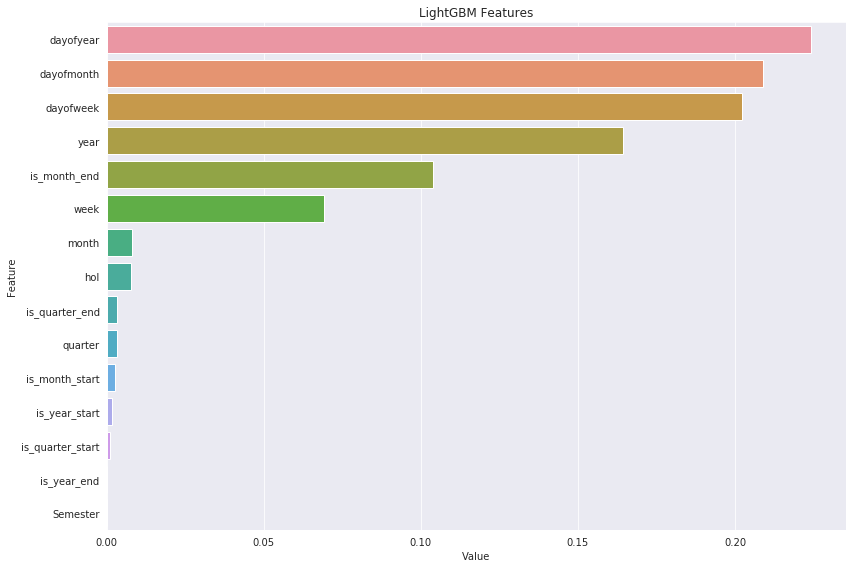

In [24]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

%matplotlib inline
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True)[:300], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [25]:
grp=Xtrain_s1['dayofmonth'].values

In [26]:
y_pred_tot_s1=[]
err=[]
from sklearn.model_selection import KFold,StratifiedKFold,TimeSeriesSplit,GroupKFold,GroupShuffleSplit
fold=GroupKFold(n_splits=20)

i=1
for train_index, test_index in fold.split(X,y,grp):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=DecisionTreeRegressor(random_state=1994,max_leaf_nodes=100,max_features=10)
    m.fit(X_train,y_train)
    preds=m.predict(X_test)
    print("err: ",mean_absolute_percentage_error(y_test,preds))
    err.append(mean_absolute_percentage_error(y_test,preds))
    p = m.predict(Xtest)
    i=i+1
    y_pred_tot_s1.append(p)

err:  96.1581000051413
err:  23.832413889466196
err:  26.954069763856687
err:  292.8126783826011
err:  97.68079322809153
err:  49.73260822894069
err:  18.941121556119448
err:  13.911960262752668
err:  17.003143029166786
err:  145.06094170301773
err:  15.838056940548654
err:  15.748332360615791
err:  10.378202904130243
err:  16.900927614010733
err:  18.611556732143306
err:  10.185504352568833
err:  223.3617838742405
err:  158.02278539395343
err:  138.07006155164055
err:  104.20590487579729


In [27]:
np.mean(err)

74.67054733244018

In [29]:
np.mean(err)

74.67054733244018

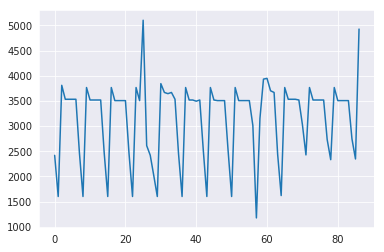

In [30]:
plt.plot(np.mean(y_pred_tot_s1,0))

In [32]:
col_to_drop=['case_count']
X,y=Xtrain_s2.drop(col_to_drop,axis=1),Xtrain_s2['case_count']
Xtest=Xtest_s2

print(X.shape,Xtest.shape)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state = 1994)

(843, 14) (93, 14)


In [33]:
from sklearn.ensemble import RandomForestRegressor
rf=DecisionTreeRegressor(random_state=1994,max_depth=10,max_features=11)
rf.fit(X_train,y_train)

p=rf.predict(X_val)

print('MAPE',mean_absolute_percentage_error(y_val,p))

MAPE 24.00650286255746


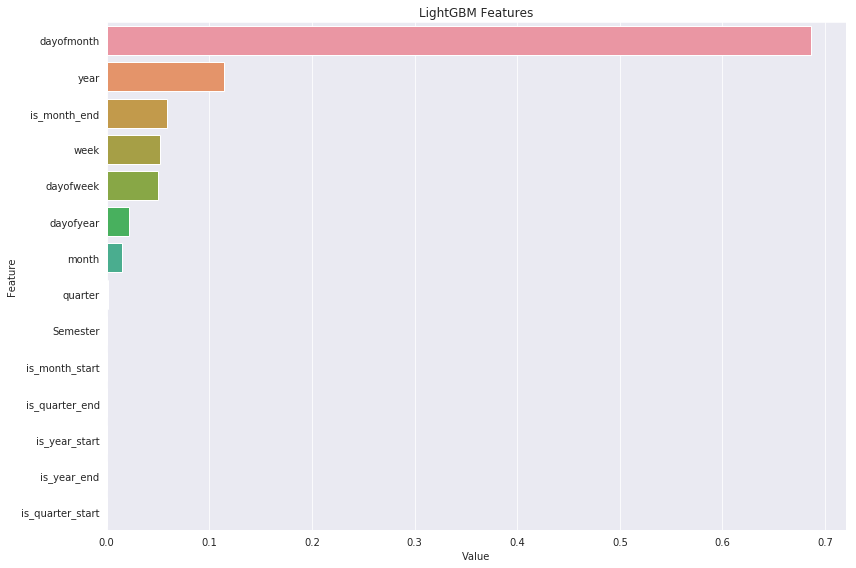

In [34]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

%matplotlib inline
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True)[:300], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [35]:
grp=Xtrain_s2['dayofyear'].values

In [36]:
y_pred_tot_s2=[]
err=[]
from sklearn.model_selection import KFold,StratifiedKFold,TimeSeriesSplit
fold=GroupKFold(n_splits=10)
i=1
for train_index, test_index in fold.split(X,y,grp):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=DecisionTreeRegressor(random_state=1994,max_features=12)
    m.fit(X_train,y_train)
    preds=m.predict(X_test)
    print("err: ",mean_absolute_percentage_error(y_test,preds))
    err.append(mean_absolute_percentage_error(y_test,preds))
    p = m.predict(Xtest)
    i=i+1
    y_pred_tot_s2.append(p)

err:  19.413530329050158
err:  21.02840180570278
err:  26.142880367255145
err:  21.270734788666427
err:  33.960312180231575
err:  28.21523341457745
err:  23.48079545345218
err:  23.205613232127682
err:  31.026905776096402
err:  22.603793795752352


In [37]:
np.mean(err)

25.034820114291215

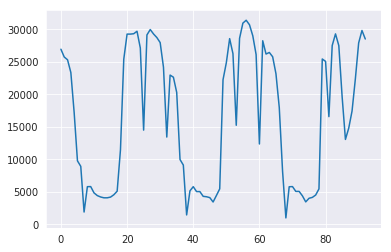

In [39]:
plt.plot(np.mean(y_pred_tot_s2,0))

In [41]:
test.loc[test.segment==1, 'case_count']=np.mean(y_pred_tot_s1,0)
test.loc[test.segment==2, 'case_count']=np.mean(y_pred_tot_s2,0)

In [42]:
test

id application_date  segment    case_count
0      1       2019-07-06        1   2419.335275
1      2       2019-07-07        1   1601.375786
2      3       2019-07-08        1   3810.980022
3      4       2019-07-09        1   3533.774295
4      5       2019-07-10        1   3533.774295
..   ...              ...      ...           ...
175  176       2019-10-20        2  17421.000000
176  177       2019-10-21        2  22355.600000
177  178       2019-10-22        2  27887.400000
178  179       2019-10-23        2  29801.800000
179  180       2019-10-24        2  28490.500000

[180 rows x 4 columns]

In [43]:
test.to_csv('kv7_dtrholidays.csv',index=False) 